### 워터셰드

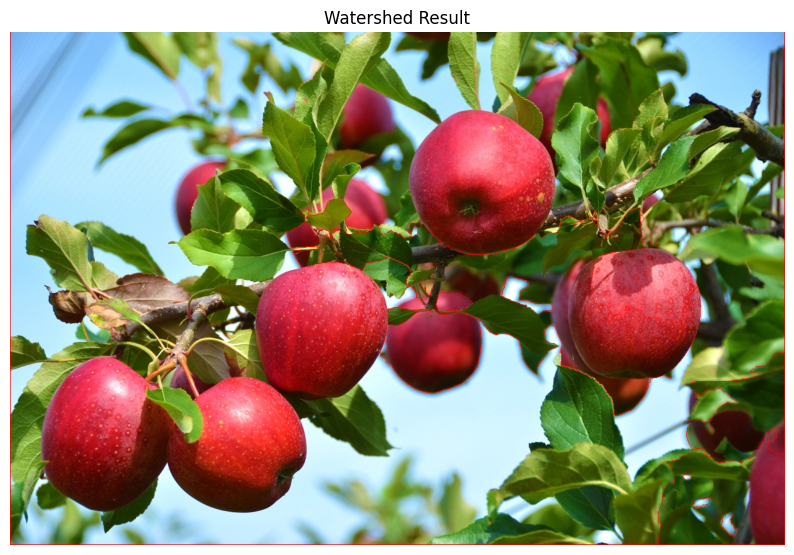

In [7]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# 1) 이미지 불러오기
img = cv.imread('apples.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# 2) 이진화 (Threshold)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# 3) 잡음 제거 (Morphology)
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

# 4) 확실한 배경 영역 (확장)
sure_bg = cv.dilate(opening, kernel, iterations=3)

# 5) 확실한 전경 영역 (거리 변환)
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# 6) 알 수 없는 영역 (배경-전경)
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

# 7) 마커 만들기
ret, markers = cv.connectedComponents(sure_fg)
markers = markers + 1  # 배경이 0이라서 1씩 올려줌
markers[unknown == 255] = 0  # 알 수 없는 영역은 0으로

# 8) 워터셰드 적용
markers = cv.watershed(img, markers)

# 9) 경계선 표시
img[markers == -1] = [0, 0, 255]  # 경계선은 빨간색

# 10) 결과 출력
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Watershed Result')
plt.axis('off')
plt.show()


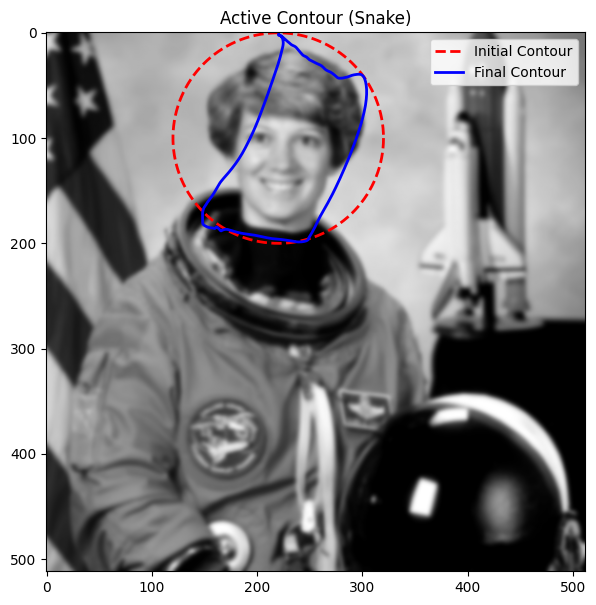

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# 이미지
image = color.rgb2gray(data.astronaut())
image = gaussian(image, 2)

# 초기 컨투어
s = np.linspace(0, 2*np.pi, 400)
x = 220 + 100*np.cos(s)
y = 100 + 100*np.sin(s)
init = np.array([x, y]).T

# 능동 외곽선
snake = active_contour(
    image,
    init,
    alpha=0.01,
    beta=5,
    gamma=0.001
)

# 결과
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image, cmap='gray')
ax.plot(init[:, 0], init[:, 1], '--r', lw=2, label='Initial Contour')
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=2, label='Final Contour')
ax.set_title('Active Contour (Snake)')
ax.legend()
plt.show()

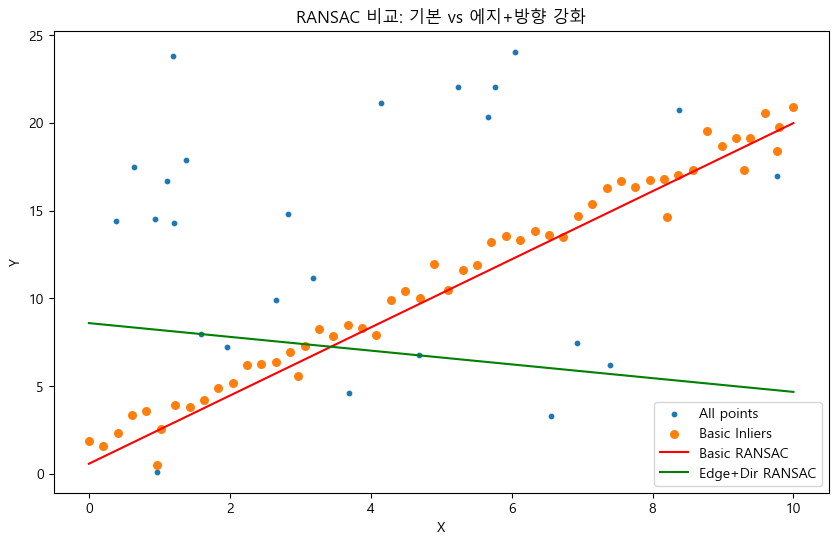

In [ ]:
#03 RANSAC 알고리즘 + 에지 강도, 에지 방향

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# -------------------------------
# 1) 샘플 데이터: 직선 + 이상치
# -------------------------------
np.random.seed(0)
N_inliers = 50
N_outliers = 30

# Inliers: y = 2x + 1 + noise
X_in = np.linspace(0, 10, N_inliers)
Y_in = 2 * X_in + 1 + np.random.normal(0, 0.5, N_inliers)

# Outliers: random points
X_out = np.random.uniform(0, 10, N_outliers)
Y_out = np.random.uniform(0, 25, N_outliers)

X_all = np.concatenate([X_in, X_out])
Y_all = np.concatenate([Y_in, Y_out])

points = np.vstack([X_all, Y_all]).T

# -------------------------------
# 2) Edge Magnitude & Direction
# -------------------------------
# 이미지에 그려서 Sobel로 그라디언트 계산
img = np.zeros((256, 256), dtype=np.uint8)

# 스케일링: (0,10)x(0,25) → (0,255)x(0,255)
X_scaled = (X_all / 10.0 * 255).astype(int)
Y_scaled = (Y_all / 25.0 * 255).astype(int)

for (x, y) in zip(X_scaled, Y_scaled):
    cv.circle(img, (x, y), 1, 255, -1)

# Sobel X, Y
grad_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
grad_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)

# Magnitude & Direction
magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
direction = np.arctan2(grad_y, grad_x)  # [-pi, pi]

# 점마다 에지 강도, 방향 추출
edge_strength = []
edge_direction = []

for (x, y) in zip(X_scaled, Y_scaled):
    edge_strength.append(magnitude[y, x])
    edge_direction.append(direction[y, x])

edge_strength = np.array(edge_strength)
edge_direction = np.array(edge_direction)

# -------------------------------
# 3) 기본 RANSAC
# -------------------------------
def ransac_basic(points, n_iter=100, threshold=1.0):
    best_model = None
    best_inliers = []

    for _ in range(n_iter):
        # 2점 랜덤 선택 → 직선 모델
        sample = points[np.random.choice(points.shape[0], 2, replace=False)]
        p1, p2 = sample

        # 직선 방정식 Ax + By + C = 0
        A = p2[1] - p1[1]
        B = p1[0] - p2[0]
        C = p2[0]*p1[1] - p1[0]*p2[1]

        # 모든 점에 대해 거리 계산
        dist = np.abs(A*points[:,0] + B*points[:,1] + C) / np.sqrt(A**2 + B**2)

        inliers = points[dist < threshold]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (A,B,C)

    return best_model, best_inliers

# -------------------------------
# 4) 강화 RANSAC: 에지 강도+방향
# -------------------------------
def ransac_edge(points, edge_strength, edge_direction, n_iter=100, threshold=1.0, dir_thresh=0.8):
    best_model = None
    best_score = -1

    for _ in range(n_iter):
        idx = np.random.choice(points.shape[0], 2, replace=False)
        p1, p2 = points[idx]

        # 직선: Ax + By + C = 0
        A = p2[1] - p1[1]
        B = p1[0] - p2[0]
        C = p2[0]*p1[1] - p1[0]*p2[1]

        # 직선 방향 벡터
        line_dir = np.array([B, -A])
        line_dir = line_dir / np.linalg.norm(line_dir)

        dist = np.abs(A*points[:,0] + B*points[:,1] + C) / np.sqrt(A**2 + B**2)

        # 방향 벡터 (에지 방향은 수직이라 법선과 비교)
        edge_dir_vec = np.vstack([np.cos(edge_direction), np.sin(edge_direction)]).T

        cos_theta = np.abs(np.sum(edge_dir_vec * line_dir, axis=1))  # 내적 절댓값

        mask = (dist < threshold) & (cos_theta > dir_thresh)

        # 가중 점수: 강도 × 방향 일치도
        score = np.sum(edge_strength[mask] * cos_theta[mask])

        if score > best_score:
            best_score = score
            best_model = (A,B,C)

    return best_model

# -------------------------------
# 5) 실행 & 시각화 비교
# -------------------------------
basic_model, basic_inliers = ransac_basic(points)
edge_model = ransac_edge(points, edge_strength, edge_direction)

def plot_line(A,B,C,color,label):
    x = np.linspace(0,10,100)
    y = -(A*x + C)/B
    plt.plot(x, y, color, label=label)

plt.figure(figsize=(10,6))
plt.scatter(X_all, Y_all, s=10, label='All points')
plt.scatter(basic_inliers[:,0], basic_inliers[:,1], s=30, label='Basic Inliers', marker='o')

plot_line(*basic_model,'r-','Basic RANSAC')
plot_line(*edge_model,'g-','Edge+Dir RANSAC')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('RANSAC 비교: 기본 vs 에지+방향 강화')
plt.show()


In [20]:
#07 sobel, scharr 비교

import cv2 as cv

# 1) 이미지 불러오기
img = cv.imread('soccer.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# -----------------------------------
# 2) Sobel 연산자 적용
# -----------------------------------
grad_x_sobel = cv.Sobel(gray, cv.CV_32F, 1, 0, ksize=3)
grad_y_sobel = cv.Sobel(gray, cv.CV_32F, 0, 1, ksize=3)

sobel_x = cv.convertScaleAbs(grad_x_sobel)
sobel_y = cv.convertScaleAbs(grad_y_sobel)

edge_strength_sobel = cv.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

# -----------------------------------
# 3) Scharr 연산자 적용
# -----------------------------------
grad_x_scharr = cv.Scharr(gray, cv.CV_32F, 1, 0)
grad_y_scharr = cv.Scharr(gray, cv.CV_32F, 0, 1)

scharr_x = cv.convertScaleAbs(grad_x_scharr)
scharr_y = cv.convertScaleAbs(grad_y_scharr)

edge_strength_scharr = cv.addWeighted(scharr_x, 0.5, scharr_y, 0.5, 0)

# -----------------------------------
# 4) 결과 출력
# -----------------------------------
cv.imshow('Original', gray)

cv.imshow('Sobel X', sobel_x)
cv.imshow('Sobel Y', sobel_y)
cv.imshow('Edge Strength (Sobel)', edge_strength_sobel)

cv.imshow('Scharr X', scharr_x)
cv.imshow('Scharr Y', scharr_y)
cv.imshow('Edge Strength (Scharr)', edge_strength_scharr)

cv.waitKey()
cv.destroyAllWindows()


### Canny 함수
| 순서  | 이름               | 역할                                        |
| --- | ---------------- | ----------------------------------------- |
| 1️ | **image**        | 입력 이미지 (흑백)                               |
| 2️ | **threshold1**   | 히스테리시스 임계값(하한)                            |
| 3️ | **threshold2**   | 히스테리시스 임계값(상한)                            |
| 4️ | **edges**        | 출력 결과                                     |
| 5️ | **apertureSize** | Sobel 커널 크기 (미분 연산자 크기)                   |
| 6️ | **L2gradient**   | gradient 크기 계산 방식 (True = 정확한 L2 norm 사용) |

| 매개변수                       | 바꿨을 때                |
| -------------------------- | -------------------- |
| `threshold1`, `threshold2` | 경계선 양 많고 적음(잡음 포함)   |
| `apertureSize`             | 에지 선이 두껍거나 얇음, 잡음 억제 |
| `L2gradient`               | 기울기 계산 방식 정밀도        |

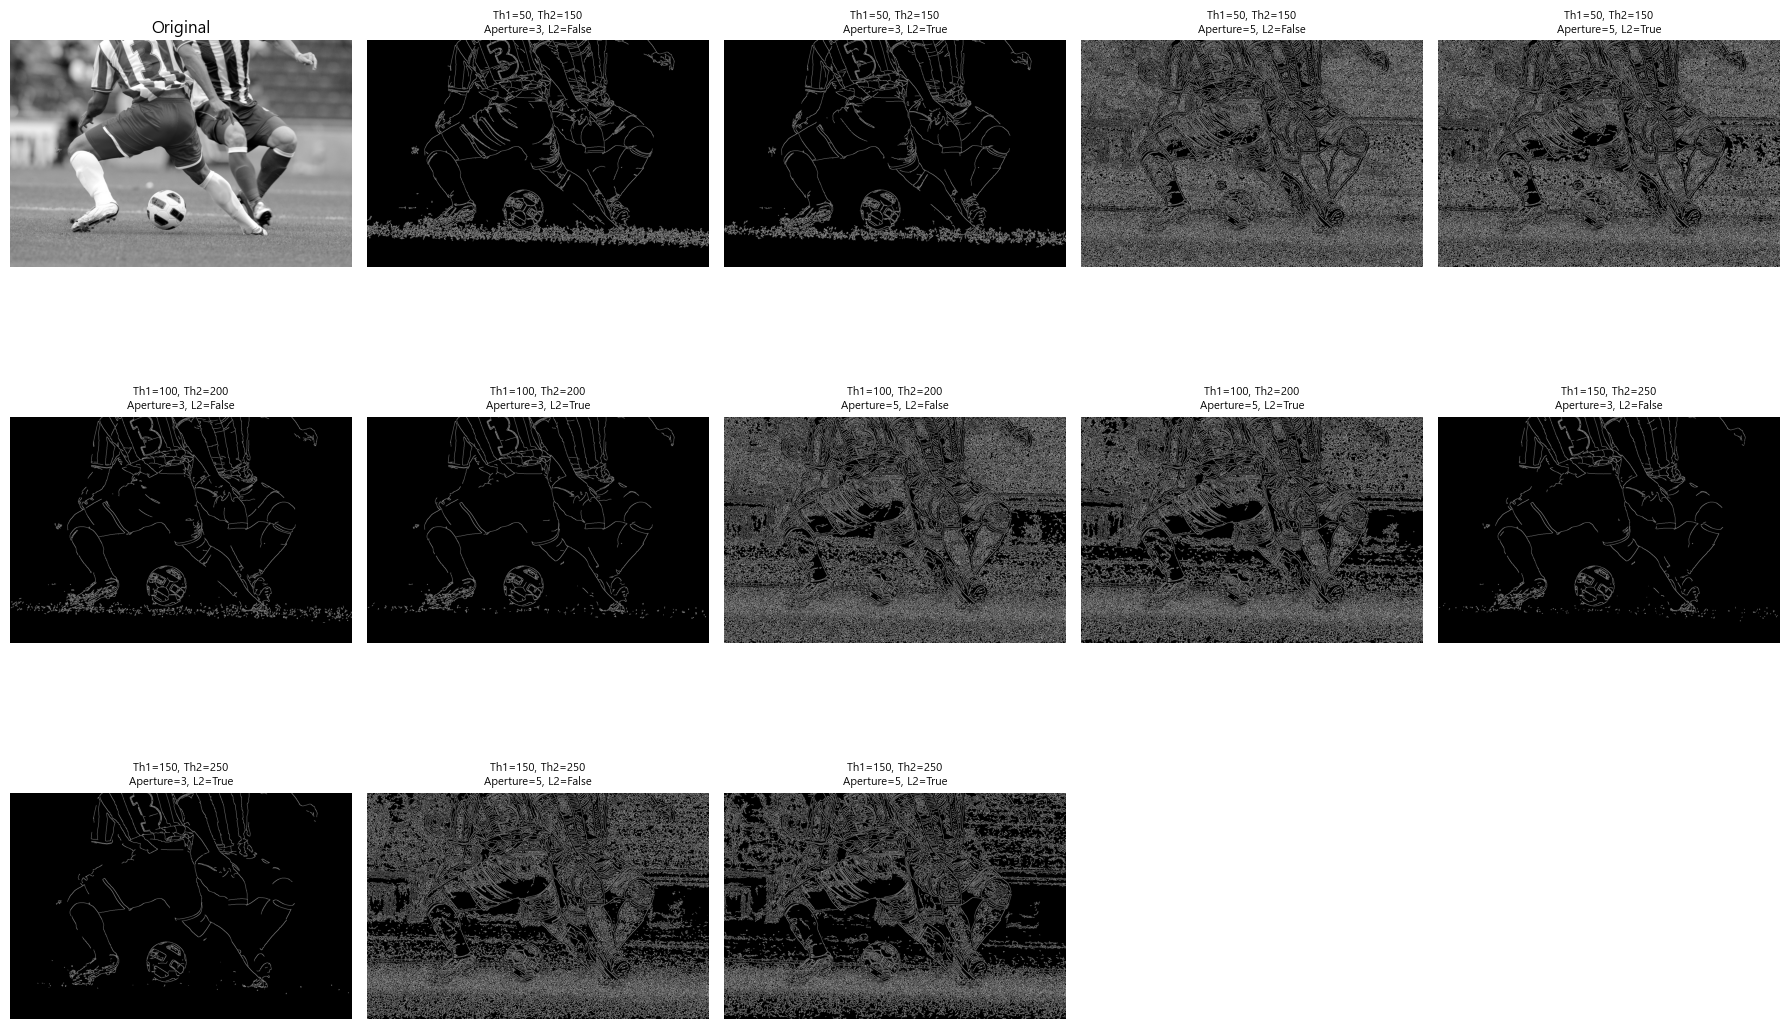

In [21]:
# 08 
import cv2 as cv
import matplotlib.pyplot as plt

# -----------------------------------
# 1) 이미지 불러오기
# -----------------------------------
img = cv.imread('soccer.jpg')  # 원하는 이미지로 변경
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# -----------------------------------
# 2) 실험 파라미터 조합
# -----------------------------------
thresholds = [
    (50, 150),
    (100, 200),
    (150, 250)
]

aperture_sizes = [3, 5]
l2_options = [False, True]

# -----------------------------------
# 3) 시각화
# -----------------------------------
plt.figure(figsize=(18, 12))

# 원본 표시
plt.subplot(3, 5, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plot_idx = 2

# 조합별로 실행
for th1, th2 in thresholds:
    for aperture in aperture_sizes:
        for l2 in l2_options:
            edges = cv.Canny(
                gray, th1, th2,
                apertureSize=aperture,
                L2gradient=l2
            )
            title = f'Th1={th1}, Th2={th2}\nAperture={aperture}, L2={l2}'
            plt.subplot(3, 5, plot_idx)
            plt.imshow(edges, cmap='gray')
            plt.title(title, fontsize=8)
            plt.axis('off')
            plot_idx += 1

plt.tight_layout()
plt.show()


In [5]:
# 09

import skimage
import numpy as np
import cv2 as cv

# [1] 샘플 이미지 불러오기 (skimage에서 제공)
img = skimage.data.coffee()

# OpenCV는 BGR 순서라서 RGB → BGR로 변환해서 표시
cv.imshow('Coffee image', cv.cvtColor(img, cv.COLOR_RGB2BGR))

# [2] SLIC Superpixel Segmentation (compactness=20)
# compactness: 색상과 공간 정보의 균형 조절 파라미터 (작으면 색상 위주, 크면 형태 유지)
# n_segments: 만들 Superpixel 수
slic1 = skimage.segmentation.slic(img, compactness=20, n_segments=600)

# SLIC 결과에 경계선 그리기
sp_img1 = skimage.segmentation.mark_boundaries(img, slic1)

# skimage는 결과가 [0,1] float이므로 OpenCV로 보려면 0~255로 변환
sp_img1 = np.uint8(sp_img1 * 255.0)

# [3] 두 번째 SLIC 세그먼트 (compactness=40)
# compactness가 더 크면 덩어리 형태가 더 균일해짐
slic2 = skimage.segmentation.slic(img, compactness=40, n_segments=600)

# 두 번째 결과도 경계선 표시
sp_img2 = skimage.segmentation.mark_boundaries(img, slic2)
sp_img2 = np.uint8(sp_img2 * 255.0)

# [4] OpenCV로 결과 시각화
# RGB → BGR 변환하여 색상 깨짐 방지
cv.imshow('Super pixels (compact 20)', cv.cvtColor(sp_img1, cv.COLOR_RGB2BGR))
cv.imshow('Super pixels (compact 50)', cv.cvtColor(sp_img2, cv.COLOR_RGB2BGR))

# [5] 키 입력 대기 후 창 닫기
cv.waitKey()
cv.destroyAllWindows()

In [1]:
# 10
import cv2 as cv
import numpy as np

# 이미지 & 초기 mask
img = cv.imread('soccer.jpg')
img_show = np.copy(img)
mask = np.zeros((img.shape[0], img.shape[1]), np.uint8)
mask[:, :] = cv.GC_PR_BGD  # 잠재적 배경

BrushSize = 9
LColor, RColor = (255, 0, 0), (0, 0, 255)

def painting(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(img_show, (x, y), BrushSize, LColor, -1)
        cv.circle(mask, (x, y), BrushSize, cv.GC_FGD, -1)
    elif event == cv.EVENT_RBUTTONDOWN:
        cv.circle(img_show, (x, y), BrushSize, RColor, -1)
        cv.circle(mask, (x, y), BrushSize, cv.GC_BGD, -1)
    elif event == cv.EVENT_MOUSEMOVE and flags == cv.EVENT_FLAG_LBUTTON:
        cv.circle(img_show, (x, y), BrushSize, LColor, -1)
        cv.circle(mask, (x, y), BrushSize, cv.GC_FGD, -1)
    elif event == cv.EVENT_MOUSEMOVE and flags == cv.EVENT_FLAG_RBUTTON:
        cv.circle(img_show, (x, y), BrushSize, RColor, -1)
        cv.circle(mask, (x, y), BrushSize, cv.GC_BGD, -1)
    cv.imshow('Painting', img_show)

while True:
    # ---------- 1) 사용자 붓칠 ----------
    img_show = np.copy(img)  # 이전 결과 덮어쓰기
    cv.imshow('Painting', img_show)
    cv.setMouseCallback('Painting', painting)

    print("붓질하고 'g' 눌러서 GrabCut, 'q'로 종료")

    # g: GrabCut, q: 종료
    while True:
        key = cv.waitKey()
        if key == ord('g'):  # GrabCut 실행
            break
        elif key == ord('q'):
            cv.destroyAllWindows()
            exit()

    # ---------- 2) GrabCut ----------
    background = np.zeros((1, 65), np.float64)
    foreground = np.zeros((1, 65), np.float64)

    cv.grabCut(img, mask, None, background, foreground, 5, cv.GC_INIT_WITH_MASK)

    # 확실/잠재적 배경 = 0, 나머지 물체 = 1
    mask2 = np.where(
        (mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD),
        0, 1
    ).astype('uint8')
    grab = img * mask2[:, :, np.newaxis]

    cv.imshow('GrabCut Result', grab)
    print("결과 확인 후 다시 붓질하려면 아무 키, 'q' 누르면 종료")
    
    key = cv.waitKey()
    if key == ord('q'):
        break

cv.destroyAllWindows()



붓질하고 'g' 눌러서 GrabCut, 'q'로 종료
결과 확인 후 다시 붓질하려면 아무 키, 'q' 누르면 종료
붓질하고 'g' 눌러서 GrabCut, 'q'로 종료
결과 확인 후 다시 붓질하려면 아무 키, 'q' 누르면 종료
